<a href="https://colab.research.google.com/github/vermakun/UMD-SS21-ECE-5831-ECU-Fingerprinting/blob/main/ecu_fingerprinting_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-Vehicle Security using Pattern Recognition Techniques (Single Record Processing)
---
*ECE 5831 - 07/28/2021 - Kunaal Verma*

## Initialization

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import splev, splrep

### Google Colab Only ###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Pre-conditioning


The dataset for this project consists of several time-series recordings of clock pulses produced by several ECUs on an in-vehicle CAN High network.

The goal is to train an artificial neural network to recognize unique signatures of each ECU in order to identify when intrusive messages are being fed to the network.

The test network has 8 trusted ECUs, with 30 records of 600 samples of the clock signal for each ECU.

Before training can begin, we must pre-condition the data in order for our algorithm to track the data being processed correctly.

The naming convention of the Dataset is as follows:

> /Dataset/ {A}\_{B}\_{C}\_{D} / {E}\_{F}.csv
>
>> A = Channel ID
>>
>> B = Physical Length of Channel
>>
>> C = Channel Core Material
>>
>> D = Project Identifier
>>
>> E = Filename Prefix
>>
>> F = Filename Record Number
>>
> E.g.
> 
>> /Dataset/CAN92_6m_Silver_uns1/CAN10_TypeD6_auns1_14.csv
>>
>> A = CAN92  B = 6m  C = Silver  D = uns1  E = CAN10_TypeD6_auns1  F = 14

In addition to Record metadata, the data within each file contains a one-dimensional numeric array of strings that represent the voltage output of the ECU measured by the phantom "Threat Detection" module at which we measured the signals.

1. Create a list of absolute paths for each record (csv file)

In [2]:
print("\n--- Data Pre-conditioning ---")

### Google Colab Only ###
!cp -r '/content/drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset' .

# Dataset path
datapath = './Dataset'

print('\nPath to Dataset:')
print(datapath)

# List of files in directory, extract recursively
file_list = []
 
for path, folders, files in os.walk(datapath):
    for file in files:
        file_list.append(os.path.join(path, file))

# Sort files by Filename Record Number, but using leading zeros
file_list0 = []

for filename in file_list:
    m = re.search('_[0-9]\.', filename)
    if m:
      found = m.group(0)
      filename = re.sub('_[0-9]\.', found[0] + '0' + found[1:-1] + '.', filename)
    file_list0.append(filename)

file_list1 = dict(zip(file_list0,file_list))
file_list2 = dict(sorted(file_list1.items(), key = lambda x:x[0]))

file_list  = list(file_list2.values())  # Original list, properly sorted
file_list0 = list(file_list2.keys())    # Modified list with leading zeros, sorted

print('\nAbsolute Paths to Records:')
for filename in file_list0[0:10]:
# for filename in file_list:
  print(filename)


--- Data Pre-conditioning ---

Path to Dataset:
./Dataset

Absolute Paths to Records:
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_01.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_02.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_03.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_04.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_05.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_06.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_07.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_08.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_09.csv
./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_10.csv


2. Analyze records sequentially, save pertinent data to a DataFrame

  a. (ID)  CAN Channel ID

  b. (PL)  Channel Physical Length

  c. (PM)  Channel Physical Material

  d. (DID) Device Record ID

  e. (Vs)  Voltage Signal data

In [3]:
# Pre-iteration instantiation
d = {}
d['Filepath'] = []
d['CAN_Id'] = []
d['CAN_PhyLen'] = []
d['CAN_PhyMat'] = []
d['CAN_RecId'] = []

# Iteratively build data dictionary
for filepath in file_list0:

  # Extract folder name of current record
  folder = os.path.basename(os.path.dirname(filepath))
  filename = os.path.basename(filepath)

  # Extract record identifiers
  id, pl, pm, did = folder.split('_')
  filename = re.split(r'_|\.',filename)

  d['Filepath'].append(filepath)
  d['CAN_Id'].append(id)
  d['CAN_PhyLen'].append(pl)
  d['CAN_PhyMat'].append(pm)
  d['CAN_RecId'].append(filename[-2])

df = pd.DataFrame.from_dict(d)

print("\nFile Metadata:")
print(df.head())


File Metadata:
                                        Filepath CAN_Id  ... CAN_PhyMat CAN_RecId
0  ./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_01.csv   CAN1  ...       Thin        01
1  ./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_02.csv   CAN1  ...       Thin        02
2  ./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_03.csv   CAN1  ...       Thin        03
3  ./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_04.csv   CAN1  ...       Thin        04
4  ./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_05.csv   CAN1  ...       Thin        05

[5 rows x 5 columns]


## Plot Raw Data (One Record)


--- Plot Raw Data ---


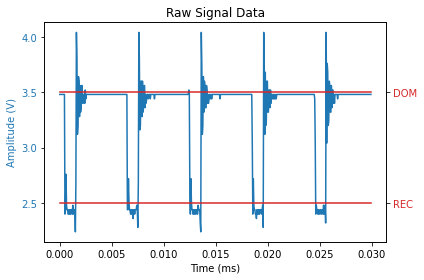

In [4]:
print("\n--- Plot Raw Data ---")

### Google Colab Only
# with open('drive/MyDrive/School/UMich Dearborn/SS21/ECE 5831/Project/Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_1.csv') as file_name:

with open('./Dataset/CAN1_2m_Thin_uns1/CAN1Aauns1_1.csv') as file_name:
    array = np.loadtxt(file_name, delimiter=",")

sample_rate = 20000 # Hz or Samples/s

t = np.arange(array.size)/sample_rate
y3_5v = t*0 + 3.5;
y2_5v = y3_5v - 1;

fig, ax1 = plt.subplots()  # create figure and instantiate left y-axis
color = 'tab:blue'
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Amplitude (V)', color=color)
ax1.plot(t, array, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks(np.arange(2.5,4.5,0.5))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(t, y3_5v, t, y2_5v, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks([2.5,3.5])
ax2.set_yticklabels(['REC','DOM'])

plt.title('Raw Signal Data')

fig.tight_layout()
plt.show()

## Peak Detection


--- Peak Detection ---


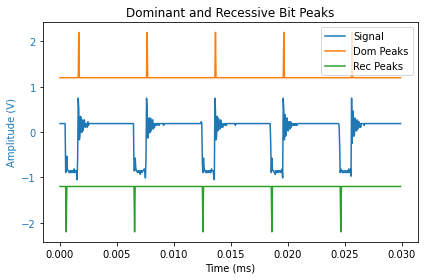


 Dominant Peak Indices:
[ 33 153 273 393 513]

Recessive Peak Indices:
[ 11 131 251 372 493]


In [5]:
print("\n--- Peak Detection ---")

# Calculate difference array
arr_diff = np.diff(array, prepend=array[0])

# Perform moving average filter, width=3, x2
w = 3
arr_diff = np.convolve(arr_diff, np.ones(w), 'valid') / w
arr_diff = np.convolve(arr_diff, np.ones(w), 'valid') / w

# Prepend zeros to offset processing delay
arr_diff = np.insert(arr_diff, 0, np.zeros((w-1)*2), axis=0)

# Crossing filter to detect dominant and recessive leading edge zones
dom_le_ts = (arr_diff >  0.2).astype(float)
rec_le_ts = (arr_diff < -0.2).astype(float)

# Find peak for each zone (dominant)
a = np.where(dom_le_ts == 1)[0].astype(float)
b = np.diff(a, prepend=0)
c = np.where(b > 1)[0]
dom_le = a[c].astype(int)

# Remove errant peaks (dominant)
corr_idx = np.concatenate((np.diff(dom_le),[np.average(np.diff(dom_le))]))
if np.min(np.diff(corr_idx)) < 100:
  corr_idx = np.where(corr_idx > np.average(corr_idx/4))[0]
  dom_le = dom_le[corr_idx]

# Find peak for each zone (recessive)
a = np.where(rec_le_ts == 1)[0].astype(float)
b = np.diff(a, prepend=0)
c = np.where(b > 1)[0]
rec_le = a[c].astype(int)

# Remove errant peaks (recessive)
corr_idx = np.concatenate((np.diff(rec_le),[np.average(np.diff(rec_le))]))
if np.min(np.diff(corr_idx)) < 60:
  corr_idx = np.where(corr_idx > np.average(corr_idx/4))[0]
  rec_le = rec_le[corr_idx]

# Pair dom and rec indices

dom_len = len(dom_le)
rec_len = len(rec_le)

dom_is_larger = []

if dom_len > rec_len:
  dom_is_larger = 1
elif rec_len > dom_len:
  dom_is_larger = 0

if not dom_is_larger == []:
  len_min = np.min((dom_len, rec_len))
  len_dif = np.abs(dom_len - rec_len) + 1

  dif_amt = []

  for i in np.arange(len_dif):
    if dom_is_larger:
      temp = dom_le[0:dom_len] - rec_le[i:dom_len+i]
    else:
      temp = dom_le[0:dom_len] - rec_le[i:dom_len+i]
    temp = np.abs(temp)
    temp = np.sum(temp)
    dif_amt.append(temp)
    
  dif_loc = np.where(np.min(dif_amt) == dif_amt)[0]
  
  if dom_is_larger:
    dom_le = dom_le[dif_loc[0]:rec_len+dif_loc[0]+1]
  else:
    rec_le = rec_le[dif_loc[0]:dom_len+dif_loc[0]+1]

# Find timestamps of dom and rec indices

dom_le_ts = np.zeros(dom_le_ts.size)
dom_le_ts[dom_le] = 1

rec_le_ts = np.zeros(rec_le_ts.size)
rec_le_ts[rec_le] = 1

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, array - np.average(array), t, dom_le_ts+1.2, t, -1.2 - rec_le_ts)
ax.tick_params(axis='y', labelcolor=color)
# offset = 0.024
# del_t = 0.003
# ax.set_xlim(left=offset, right=offset+del_t)
plt.legend(['Signal','Dom Peaks','Rec Peaks'])
plt.title('Dominant and Recessive Bit Peaks')

fig.tight_layout()
plt.show()

print("\n Dominant Peak Indices:")
print(dom_le)
print("\nRecessive Peak Indices:")
print(rec_le)

## Pre-Peak Steady State Detection


--- Pre-Peak Detection ---


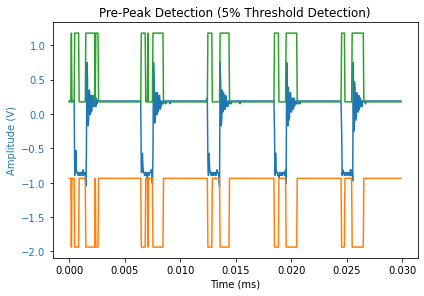

In [6]:
print("\n--- Pre-Peak Detection ---")

# Crossing filter to detect pre-dominant steady state (Before Leading-edge)
dom_bl_ts = np.abs(np.diff(array - 2.5, prepend = array[0]))
w = 5
dom_bl_ts = np.convolve(dom_bl_ts, np.ones(w), 'valid') / w
dom_bl_ts = np.insert(dom_bl_ts, 0, np.zeros(w-1), axis=0)
dom_bl_ts = 1-(dom_bl_ts > 0.05).astype(float)

# Crossing filter to detect pre-recessive steady state (Before Leading-edge)
rec_bl_ts = np.abs(np.diff(3.5 - array, prepend = array[0]))
w = 5
rec_bl_ts = np.convolve(rec_bl_ts, np.ones(w), 'valid') / w
rec_bl_ts = np.insert(rec_bl_ts, 0, np.zeros(w-1), axis=0)
rec_bl_ts = 1-(rec_bl_ts > 0.05).astype(float)

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, array - np.average(array), t, dom_bl_ts - np.average(array)/1.7, t, -rec_bl_ts + np.average(array)/2.8)
ax.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Pre-Peak Detection (5% Threshold Detection)')

plt.show()


 Dominant Peak Indices:
[ 33 153 273 393 513]

 Dominant Pre-Peak Indices:
[ 29 150 271 390 509]

Recessive Peak Indices:
[ 11 131 251 372 493]

Recessive Pre-Peak Indices:
[  9 129 249 369 490]


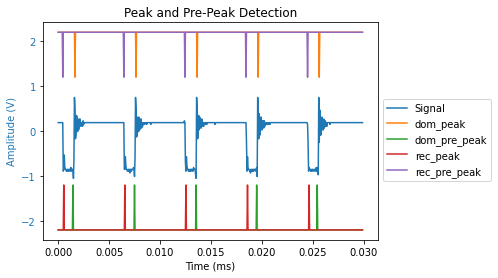

In [7]:
## Find the the last instance of steady state prior to dominant peaks
# Indices for dominant peaks
ii = np.where(dom_le_ts == 1)
dom_le = ii[0]

jj = np.zeros(dom_le.size).astype(int)

for k in np.arange(0,dom_le.size):
  # "Dominant-low steady state" indices before peak
  j = np.where(dom_bl_ts[0:dom_le[k]] == 1)
  j = j[0]
  

  # Find nearest index before dominant peak
  min_idx = j-dom_le[k]
  min_idx = min_idx[np.where(np.min(np.abs(min_idx)) == np.abs(min_idx))[0]]
  jj[k] = ((min_idx + dom_le[k])[0])

# Dominant prior-to-peak steady-state indices
dom_bl_ts2 = np.zeros(dom_bl_ts.size, dtype=int)
dom_bl_ts2[jj] = 1
dom_bl = jj

## Find the the last instance of steady state prior to recessive peaks
# Indices for recessive peaks
ii = np.where(rec_le_ts == 1)
rec_le = ii[0]

jj = np.zeros(rec_le.size).astype(int)

for k in np.arange(0,rec_le.size):
  # "Recesive-low steady state" indices before peak
  j = np.where(rec_bl_ts[0:rec_le[k]] == 1)
  j = j[0]

  # Find nearest index before recessive peak
  min_idx = j-rec_le[k]
  min_idx = min_idx[np.where(np.min(np.abs(min_idx)) == np.abs(min_idx))[0]]
  jj[k] = ((min_idx + rec_le[k])[0])

# Recessive prior-to-peak steady-state indices
rec_bl_ts2 = np.zeros(rec_bl_ts.size, dtype=int)
rec_bl_ts2[jj] = 1
rec_bl = jj

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, array - np.average(array),
         t,  2.2 - dom_le_ts, t, -2.2 + dom_bl_ts2,
         t, -2.2 + rec_le_ts, t,  2.2 - rec_bl_ts2)
ax.tick_params(axis='y', labelcolor=color)
ax.legend(['Signal','dom_peak','dom_pre_peak','rec_peak','rec_pre_peak'], bbox_to_anchor = (1, 0.67))
plt.title('Peak and Pre-Peak Detection')

print("\n Dominant Peak Indices:")
print(dom_le)
print("\n Dominant Pre-Peak Indices:")
print(dom_bl)
print("\nRecessive Peak Indices:")
print(rec_le)
print("\nRecessive Pre-Peak Indices:")
print(rec_bl)

## Peak Time (*)

In [8]:
print("\n--- Peak Time ---")

dom_pt = (dom_le-dom_bl)/sample_rate
print("\n Dominant Peak Time (s):")
print(dom_pt)

rec_pt = (rec_le-rec_bl)/sample_rate
print("\nRecessive Peak Time (s):")
print(rec_pt)


--- Peak Time ---

 Dominant Peak Time (s):
[0.0002  0.00015 0.0001  0.00015 0.0002 ]

Recessive Peak Time (s):
[0.0001  0.0001  0.0001  0.00015 0.00015]


## Steady State Values and Errors (*)


--- Steady State Values and Errors ---

 Dominant Steady State Value (V):
[3.         3.48       3.48210526 3.48       3.47789474]

 Dominant Steady State Error (V):
[-0.5        -0.02       -0.01789474 -0.02       -0.02210526]

Recessive Steady State Value (V):
[2.44842105 2.44       2.41684211 2.44210526 2.45894737]

Recessive Steady State Error (V):
[-0.05157895 -0.06       -0.08315789 -0.05789474 -0.04105263]


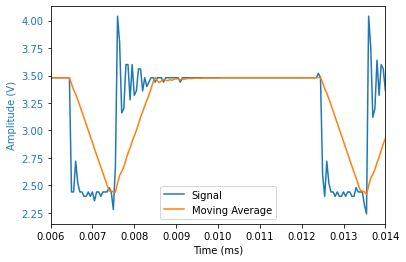

In [9]:
print("\n--- Steady State Values and Errors ---")

# Perform moving average filter, width=19
w = 19
arr_avg = np.convolve(array, np.ones(w), 'valid') / w
arr_avg = np.insert(arr_avg, 0, arr_avg[0]*np.ones(w-1), axis=0)

# Extract Steady State Value from previous Steady State Index
# *1* Need to add logic to handle Dominant and Recessive order...
dom_ssv_idx = rec_bl
# dom_ssv_idx = np.append(dom_ssv_idx[1:],arr_avg.size-1)    # *1* first attempt
rec_ssv_idx = dom_bl

dom_ssv = arr_avg[dom_ssv_idx]
rec_ssv = arr_avg[rec_ssv_idx]

# Calculate Steady State Error
dom_sse = arr_avg[dom_ssv_idx] - 3.5
rec_sse = arr_avg[rec_ssv_idx] - 2.5


print("\n Dominant Steady State Value (V):")
print(dom_ssv)
print("\n Dominant Steady State Error (V):")
print(dom_sse)
print("\nRecessive Steady State Value (V):")
print(rec_ssv)
print("\nRecessive Steady State Error (V):")
print(rec_sse)

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, array, t, arr_avg)
ax.tick_params(axis='y', labelcolor=color)
ax.set_xlim(left=0.006, right= 0.014)
plt.legend(['Signal','Moving Average']);


## Percent Overshoot (*)

In [10]:
print("\n--- Percent Overshoot ---")

dom_pv = array[dom_le]
rec_pv = array[rec_le]

try:
  dom_po = 100 * (dom_pv - dom_ssv) / dom_ssv
  rec_po = 100 * (rec_ssv - rec_pv) / rec_ssv
except:
  dom_po = 100 * (dom_pv - np.average(dom_ssv)) / np.average(dom_ssv)
  rec_po = 100 * (np.average(rec_ssv) - rec_pv) / np.average(rec_ssv)


print("\n Dominant Overshoot (%):")
print(dom_po)
print("\nRecessive Overshoot (%):")
print(rec_po)


--- Percent Overshoot ---

 Dominant Overshoot (%):
[ 26.66666667   9.1954023    7.98065296   8.04597701 -12.59079903]

Recessive Overshoot (%):
[ 3.43938091e-01 -1.82003775e-14  6.96864111e-01 -1.13793103e+01
 -8.56164384e-01]


## Settling Time (*)


--- Settling Time ---

 Dominant Settling Time (s):
[0.00065 0.00065 0.00065 0.00675 0.00075]

Recessive Settling Time (s):
[0.0012  0.0012  0.0011  0.00105 0.0012 ]


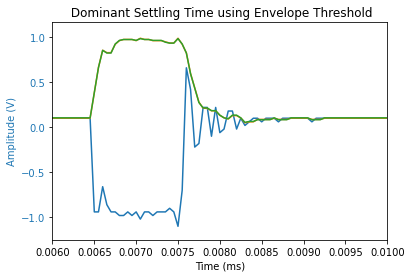

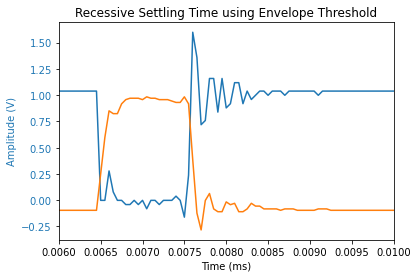

In [11]:
print("\n--- Settling Time ---")

ss_rng = 0.05   # 5% Steady State Range of 1V Vpp design

# Perform moving average filter, width=3
## Find index and time of settling point (dominant)
w = 3
arr_avg1 = np.convolve(np.abs(array-np.average(dom_ssv)), np.ones(w), 'valid') / w
arr_avg1 = np.insert(arr_avg1, 0, arr_avg1[0]*np.ones(w-1), axis=0)

arr_avg11 = np.abs(np.round(arr_avg1,decimals=2))
dom_st_idx = np.where(arr_avg11 <= ss_rng)[0]
dom_st = np.zeros(dom_le.size).astype(int)

if dom_st_idx.size != 0:
  for i in np.arange(dom_le.size):
      dom_st_idx[dom_st_idx <= dom_le[i]] = -array.size
      j = np.where(
            np.min(np.abs(dom_st_idx - dom_le[i])) 
              == np.abs(dom_st_idx - dom_le[i])
          )[0][-1]
      dom_st[i] = dom_st_idx[j]
  dom_st = dom_st.astype(int)
else:
  dom_st = np.concatenate((dom_le[1:],[array.size-1]))

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, array - np.average(dom_ssv), t, arr_avg1, t, arr_avg11)
ax.tick_params(axis='y', labelcolor=color)
ax.set_xlim(left=0.006, right= 0.010)
plt.title(' Dominant Settling Time using Envelope Threshold')

dom_st_s = t[dom_st] - t[dom_le]

## Find index and time of settling point (recessive)
w = 3
arr_avg2 = np.convolve(np.average(dom_ssv)-array, np.ones(w), 'valid') / w
arr_avg2 = np.insert(arr_avg2, 0, arr_avg2[0]*np.ones(w-1), axis=0)

arr_avg22 = np.abs(np.round(arr_avg2,decimals=2))
rec_st_idx = np.where(arr_avg22 <= ss_rng)[0]
rec_st = np.zeros(rec_le.size)
for i in np.arange(rec_le.size):
    rec_st_idx[rec_st_idx <= rec_le[i]] = -array.size
    j = np.where(
          np.min(np.abs(rec_st_idx - rec_le[i])) 
            == np.abs(rec_st_idx - rec_le[i])
        )[0][-1]
    rec_st[i] = rec_st_idx[j]
rec_st = rec_st.astype(int)

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, array - np.average(rec_ssv), t, arr_avg2)
ax.tick_params(axis='y', labelcolor=color)
ax.set_xlim(left=0.006, right= 0.010)
plt.title('Recessive Settling Time using Envelope Threshold')

rec_st_s = t[rec_st] - t[rec_le]

print("\n Dominant Settling Time (s):")
print(dom_st_s)
print("\nRecessive Settling Time (s):")
print(rec_st_s)

## Rise Time (*)


--- Rise Time ---

 Dominant Rise Time (s):
[0.00025 0.0002  0.00015 0.0002  0.0002 ]

Recessive Rise Time (s):
[0.0001  0.0001  0.0001  0.00015 0.00015]


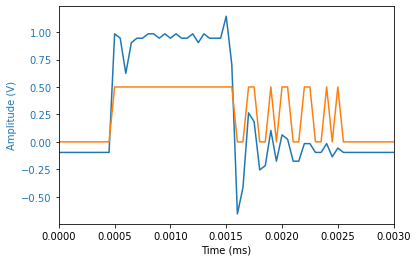

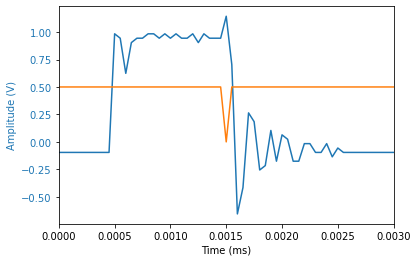

In [12]:
print("\n--- Rise Time ---")

dom_rt_ts = (array.copy() - np.average(rec_ssv) <= 1).astype(int)
dom_rt_idx = np.where(dom_rt_ts == 1)[0]

dom_rt = np.zeros(dom_le.size)

for i in np.arange(dom_le.size):
  j = np.where(np.min(np.abs(dom_rt_idx - dom_le[i])) == np.abs(dom_rt_idx - dom_le[i]))[0][-1]
  dom_rt[i] = dom_rt_idx[j]

dom_rt = dom_rt.astype(int)
dom_rt_s = t[dom_rt] - t[dom_bl]

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, -array + np.average(dom_ssv), t, 0.5*dom_rt_ts)
ax.tick_params(axis='y', labelcolor=color)
offset = 0.0
del_t = 0.003
ax.set_xlim(left=offset, right=offset+del_t);

rec_rt_ts = (-array.copy() + np.average(dom_ssv) <= 1).astype(int)
rec_rt_idx = np.where(rec_rt_ts == 1)[0]

rec_rt = np.zeros(rec_le.size)

for i in np.arange(rec_le.size):
  j = np.where(np.min(np.abs(rec_rt_idx - rec_le[i])) == np.abs(rec_rt_idx - rec_le[i]))[0][-1]
  rec_rt[i] = rec_rt_idx[j]

rec_rt = rec_rt.astype(int)

rec_rt_s = t[rec_rt] - t[rec_bl]

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, -array + np.average(dom_ssv), t, 0.5*rec_rt_ts)
ax.tick_params(axis='y', labelcolor=color)
offset = 0.0
del_t = 0.003
ax.set_xlim(left=offset, right=offset+del_t);

print("\n Dominant Rise Time (s):")
print(dom_rt_s)
print("\nRecessive Rise Time (s):")
print(rec_rt_s)

## Delay Time (*)


--- Delay Time ---

 Dominant Delay Time (s):
[1.e-04 5.e-05 0.e+00 5.e-05 1.e-04]

Recessive Delay Time (s):
[0.e+00 0.e+00 0.e+00 5.e-05 5.e-05]


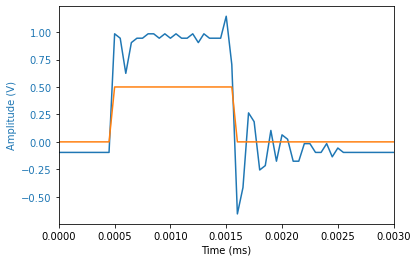

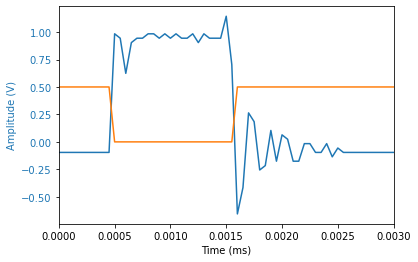

In [13]:
print("\n--- Delay Time ---")

dom_dt_ts = (array.copy() - np.average(rec_ssv) <= 0.5).astype(int)
dom_dt_idx = np.where(dom_dt_ts == 1)[0]

dom_dt = np.zeros(dom_le.size)

for i in np.arange(dom_le.size):
  j = np.where(np.min(np.abs(dom_dt_idx - dom_le[i])) == np.abs(dom_dt_idx - dom_le[i]))[0][-1]
  dom_dt[i] = dom_dt_idx[j]

dom_dt = dom_dt.astype(int)
dom_dt_s = t[dom_dt] - t[dom_bl]

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, -array + np.average(dom_ssv), t, 0.5*dom_dt_ts)
ax.tick_params(axis='y', labelcolor=color)
offset = 0.0
del_t = 0.003
ax.set_xlim(left=offset, right=offset+del_t);

rec_dt_ts = (-array.copy() + np.average(dom_ssv) <= 0.5).astype(int)
rec_dt_idx = np.where(rec_dt_ts == 1)[0]

rec_dt = np.zeros(rec_le.size)

for i in np.arange(rec_le.size):
  j = np.where(np.min(np.abs(rec_dt_idx - rec_le[i])) == np.abs(rec_dt_idx - rec_le[i]))[0][-1]
  rec_dt[i] = rec_dt_idx[j]

rec_dt = rec_dt.astype(int)
rec_dt_s = t[rec_dt] - t[rec_bl]

fig, ax = plt.subplots()
color = 'tab:blue'
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (V)', color=color)
ax.plot(t, -array + np.average(dom_ssv), t, 0.5*rec_dt_ts)
ax.tick_params(axis='y', labelcolor=color)
offset = 0.0
del_t = 0.003
ax.set_xlim(left=offset, right=offset+del_t);

print("\n Dominant Delay Time (s):")
print(dom_dt_s)
print("\nRecessive Delay Time (s):")
print(rec_dt_s)

## Spectral Density (*)


--- Spectral Density ---

 Dominant Pulse Spectral Densities:
 
[1.66186281e-06 1.33880430e-09 2.80025090e-09 1.54618163e-08
 1.31759525e-08 2.79677774e-08 2.77920034e-08 7.69530968e-09
 1.04777910e-08 1.17416874e-08]


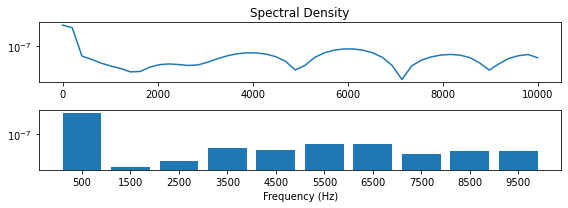

 
[1.58153371e-06 3.00370433e-09 1.13197065e-08 1.74044247e-08
 1.51207485e-08 1.72128167e-08 3.94755168e-08 1.50881852e-08
 3.20095354e-09 1.70508242e-08]


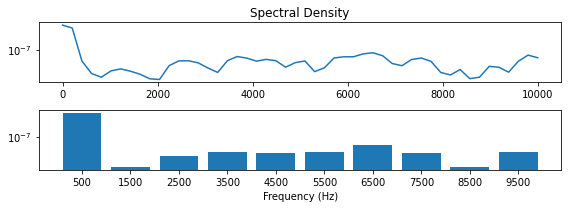

 
[1.92374968e-06 8.03289810e-09 5.05278446e-09 2.31758412e-08
 9.11172723e-09 1.29068841e-08 3.20928927e-08 8.89329534e-09
 5.11181032e-09 1.47363147e-08]


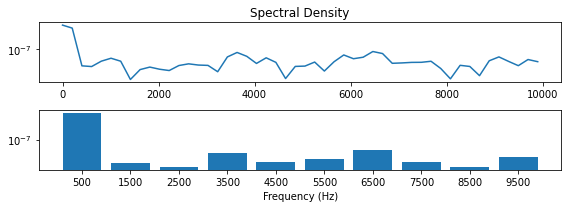

 
[1.93277742e-06 2.28557888e-09 1.49527099e-09 8.69534107e-09
 1.36575077e-08 2.02740156e-08 2.61134646e-08 5.62201014e-09
 1.00913765e-08 2.95543212e-08]


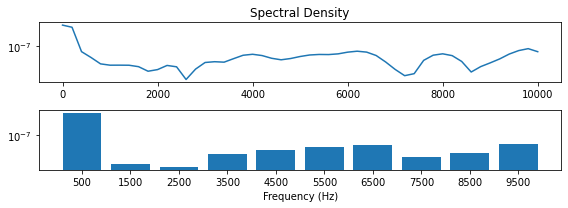


Recessive Pulse Spectral Densities:
 
[1.98511119e-05 2.43316825e-05 8.94945994e-07 4.48145760e-09
 5.89556541e-07 9.61365421e-07 1.18747169e-06 1.40249160e-06
 1.29430636e-06 1.52707745e-07]


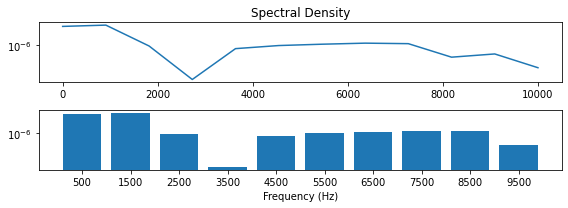

 
[2.01789330e-05 2.50019036e-05 7.27226653e-07 6.68470829e-09
 7.73920440e-07 8.96342327e-07 1.21365770e-06 9.03530564e-07
 1.01218724e-06 8.13991896e-08]


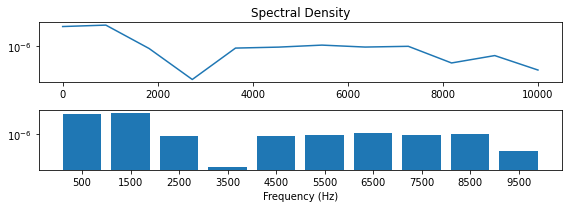

 
[2.11145201e-05 2.69882813e-05 9.79548255e-07 6.21008698e-08
 3.36947030e-07 1.09532253e-06 1.16388308e-06 4.79257527e-07
 9.79968741e-07 4.02452143e-07]


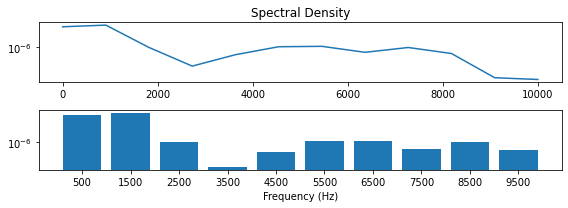

 
[1.88151271e-05 2.20825892e-05 1.08307555e-06 4.66756903e-09
 1.35128636e-07 6.46514203e-08 4.92271601e-07 3.73516889e-07
 3.23346869e-07 7.94192215e-07]


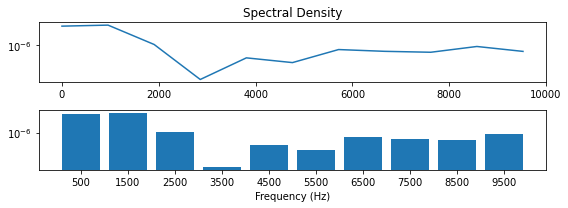

 
[1.82256646e-05 1.82803423e-05 6.33115978e-07 2.44475129e-07
 5.52652334e-07 8.14114468e-08 5.56605400e-07 6.47851011e-08
 4.48975243e-08 1.65723534e-07]


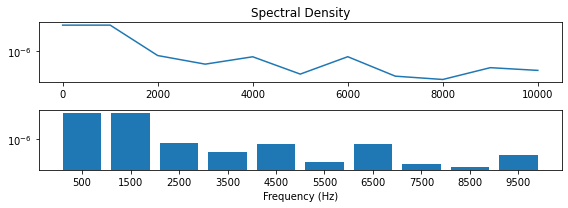

In [14]:
print("\n--- Spectral Density ---")

# Separate pulses

index_shift = -5

dom_le_sd = dom_le.copy() + index_shift
rec_le_sd = rec_le.copy() + index_shift

# Find the start/end pulse indices

if dom_le[0] <= rec_le[0]:
  if len(dom_le) > len(rec_le):
    dom_le_sd = dom_le_sd[0:-1]
  idx_dom_se = np.array([dom_le_sd,rec_le_sd])
  idx_rec_se = np.array([rec_le_sd[0:-1],dom_le_sd[1:]])

else:
  if len(rec_le) > len(dom_le):
    rec_le_sd = rec_le_sd[0:-1]
  idx_rec_se = np.array([rec_le_sd,dom_le_sd])
  idx_dom_se = np.array([dom_le_sd[0:-1],rec_le_sd[1:]])

# Remove pulses that don't provide enough steady-state information from the prev pulse

if idx_dom_se[0][0] < -index_shift:
  idx_dom_se = np.array([idx_dom_se[0][1:],idx_dom_se[1][1:]])

if idx_rec_se[0][0] < -index_shift:
  idx_rec_se = np.array([idx_rec_se[0][1:],idx_rec_se[1][1:]])

# Check for out-or-order index error

if idx_dom_se[0][0] > idx_dom_se[1][0]:
  temp1 = np.array([idx_dom_se[1],idx_dom_se[0]])
  temp2 = np.array([idx_dom_se[0],idx_rec_se[1]])

  idx_dom_se = temp2
  idx_rec_se = temp1

# Copy pulse raw data using start/end indices

dom_pulse_data = []
for i in np.arange(len(idx_dom_se[0])):
  dom_pulse_data.append(array[idx_dom_se[0][i]:idx_dom_se[1][i]])

rec_pulse_data = []
for i in np.arange(len(idx_rec_se[0])):
  rec_pulse_data.append(array[idx_rec_se[0][i]:idx_rec_se[1][i]])

# Reset indexes
idx_dom_se = idx_dom_se - index_shift
idx_rec_se = idx_rec_se - index_shift

def plot_binned_sd(Pxx_den, n, ax):

  nbins = n

  Pxx_hist = []

  bs = Pxx_den.size/nbins
  bs = round(bs)

  for i in np.arange(nbins):
    idx_s = i*bs
    idx_e = (i+1)*bs
    if idx_e >= Pxx_den.size:
      idx_e = Pxx_den.size - 1

    Pxx_hist.append(np.average(Pxx_den[idx_s:idx_e]))

  f_hist = sample_rate/nbins/2
  f_hist = np.floor((f_hist*(np.arange(nbins)) + f_hist*(np.arange(nbins)+1))/2).astype(int)

  adj = np.floor(np.min(Pxx_hist))
  max = np.ceil(np.max(Pxx_hist))
  stp = np.round((max - adj)/6)

  if nbins <=10:
    xticks = np.arange(0,nbins)
    xtick_labels = f_hist[np.arange(0,nbins)]
  else:
    xticks       = np.linspace(0,nbins,11)
    xtick_labels = (np.arange(0,nbins-1)*sample_rate/2/(len(xticks)-1)).astype(int)

  Pxx_hist = np.nan_to_num(Pxx_hist)

  ax.bar(np.arange(nbins),Pxx_hist-adj)
  ax.set_xticks(xticks)
  ax.set_xticklabels(xtick_labels)
  ax.set_yscale ('log')

  return Pxx_hist

print('\n Dominant Pulse Spectral Densities:')

dom_sd = []

for i in np.arange(len(dom_pulse_data)):
  f, pd = signal.welch(dom_pulse_data[i], sample_rate, nperseg=len(dom_pulse_data[i]))
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 3), tight_layout=True)
  ax1.plot(f, pd)
  ax1.set_yscale ('log')
  ax1.set_title('Spectral Density')
  ax2.set_xlabel('Frequency (Hz)')
  
  dom_sd.append(plot_binned_sd(pd, 10, ax2))
  
  print(' ')
  print(dom_sd[-1])
  
  plt.show()

print('\nRecessive Pulse Spectral Densities:')
rec_sd = []

for i in np.arange(len(rec_pulse_data)):
  f, pd = signal.welch(rec_pulse_data[i], sample_rate, nperseg=len(rec_pulse_data[i]))
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 3), tight_layout=True)
  ax1.plot(f, pd)
  ax1.set_yscale ('log')
  ax1.set_title('Spectral Density')
  ax2.set_xlabel('Frequency (Hz)')

  rec_sd.append(plot_binned_sd(pd, 10, ax2))

  print(' ')
  print(rec_sd[-1])
  
  plt.show()

## SNR (*)

[10.779477268340042, 9.852625174282597, 11.601469596382268, 10.987144440679895]


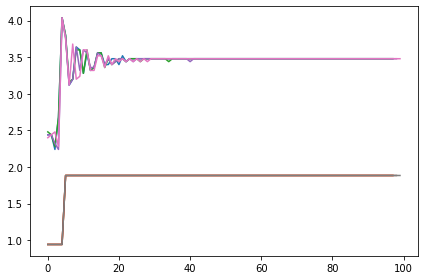

In [18]:
fig, ax = plt.subplots(tight_layout=True)

dom_snr = []
for i in np.arange(len(dom_pulse_data)):
  cur_array = dom_pulse_data[i]
  signl = (np.arange(len(cur_array)) > -index_shift-1).astype(float)*np.average(dom_ssv) + \
    (np.arange(len(cur_array)) <= -index_shift-1).astype(float)*np.average(rec_ssv)
  noise = signl - cur_array
  
  f, s_pd = signal.welch(signl, sample_rate, nperseg=len(signl))
  f, n_pd = signal.welch(noise, sample_rate, nperseg=len(noise))

  Ps = sum(s_pd)
  Pn = sum(n_pd)

  dom_snr.append(10*np.log10(Ps/Pn))

  plt.plot(cur_array)
  plt.plot(signl-1.5)

print(dom_snr)

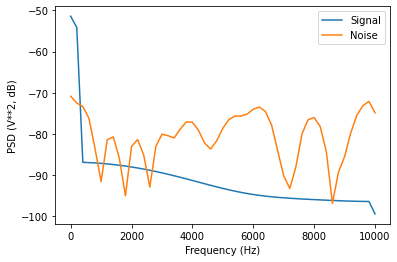

In [19]:
plt.plot(f, 10*np.log10(s_pd), f, 10*np.log10(n_pd))
plt.ylabel('PSD (V**2, dB)')
plt.xlabel('Frequency (Hz)')
plt.legend(['Signal','Noise'])

[7.661329222133954, 7.932340105966692, 7.644263850175074, 9.32720912159182, 15.41712363594428]


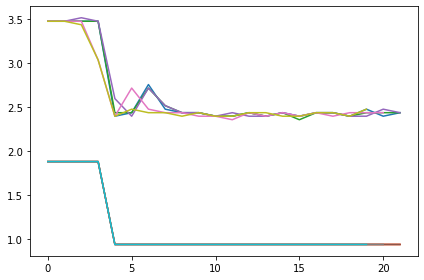

In [27]:
fig, ax = plt.subplots(tight_layout=True)

rec_snr = []
for i in np.arange(len(rec_pulse_data)):
  cur_array = rec_pulse_data[i]
  signl = (np.arange(len(cur_array)) > -index_shift-2).astype(float)*np.average(rec_ssv) + \
    (np.arange(len(cur_array)) <= -index_shift-2).astype(float)*np.average(dom_ssv)
  noise = signl - cur_array
  
  f, s_pd = signal.welch(signl, sample_rate, nperseg=len(signl))
  f, n_pd = signal.welch(noise, sample_rate, nperseg=len(noise))

  Ps = sum(s_pd)
  Pn = sum(n_pd)

  rec_snr.append(10*np.log10(Ps/Pn))

  plt.plot(cur_array)
  plt.plot(signl-1.5)

print(rec_snr)

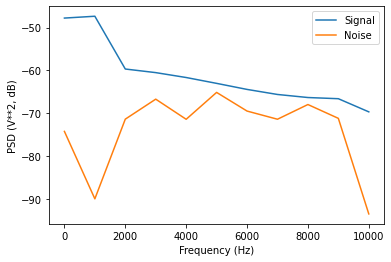

In [28]:
plt.plot(f, 10*np.log10(s_pd), f, 10*np.log10(n_pd))
plt.ylabel('PSD (V**2, dB)')
plt.xlabel('Frequency (Hz)')
plt.legend(['Signal','Noise'])

## Mean and Median Frequency (*)

[475.28420938144615, 564.35555288545, 399.7659902174099, 491.7912732469793]
[145.5, 151.19, 140.96, 145.74]


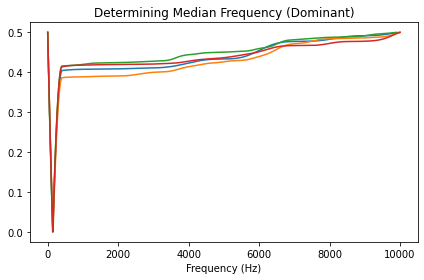

In [26]:
fig, ax = plt.subplots(tight_layout=True)

dom_meanfreq = []
dom_medfreq = []
for i in np.arange(len(dom_pulse_data)):
  cur_pulse = dom_pulse_data[i]
  f, pd = signal.welch(cur_pulse, sample_rate, nperseg=len(cur_pulse))

  dom_meanfreq.append(np.sum(pd*f)/np.sum(pd))

  spl = splrep(f, pd, k=1)
  x2 = np.arange(f[0], f[-1],0.01)
  y2 = splev(x2, spl)

  y21 = y2/np.sum(y2)                          # Normalize spectra
  y22 = np.cumsum(y21)                         # Cummulative sum (CDF for SPD)
  y23 = y22-0.5                                # Subtract 50% of energy
  y24 = abs(y23)                               # Abs value to create a minima
  y25 = np.where(np.min(y24) == y24)[0][-1]    # Locate minima index
  dom_medfreq.append(x2[y25])                  # Retrieve minima frequency  

  plt.plot(x2,y24)
  plt.xlabel('Frequency (Hz)')
  plt.title('Determining Median Frequency (Dominant)')

print(dom_meanfreq)
print(dom_medfreq)

[1156.6917329306261, 1055.3413295232128, 982.6889194501441, 943.5520147157733, 763.7997098093149]
[849.51, 831.89, 823.28, 822.72, 816.47]


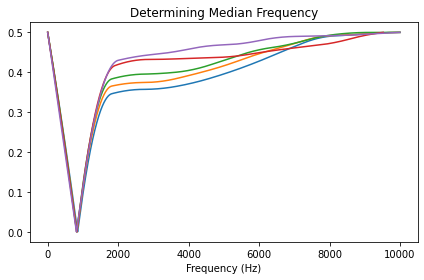

In [25]:
fig, ax = plt.subplots(tight_layout=True)

rec_meanfreq = []
rec_medfreq = []
for i in np.arange(len(rec_pulse_data)):
  cur_pulse = rec_pulse_data[i]
  f, pd = signal.welch(cur_pulse, sample_rate, nperseg=len(cur_pulse))

  rec_meanfreq.append(np.sum(pd*f)/np.sum(pd))

  spl = splrep(f, pd, k=1)
  x2 = np.arange(f[0], f[-1],0.01)
  y2 = splev(x2, spl)

  y21 = y2/np.sum(y2)                          # Normalize spectra
  y22 = np.cumsum(y21)                         # Cummulative sum (CDF for SPD)
  y23 = y22-0.5                                # Subtract 50% of energy
  y24 = abs(y23)                               # Abs value to create a minima
  y25 = np.where(np.min(y24) == y24)[0][-1]    # Locate minima index
  rec_medfreq.append(x2[y25])                  # Retrieve minima frequency  

  plt.plot(x2,y24)
  plt.xlabel('Frequency (Hz)')
  plt.title('Determining Median Frequency (Recessive)')

print(rec_meanfreq)
print(rec_medfreq)